In [1]:
import numpy as np
import matplotlib.pyplot as plt
from parse import parse
import math
import time
import cv2

In [2]:
train_images, train_labels = parse('facedata/facedatatrain', 'facedata/facedatatrainlabels', True)
validation_images, validation_labels = parse('facedata/facedatavalidation', 'facedata/facedatavalidationlabels', True)
test_images, test_labels = parse('facedata/facedatatest', 'facedata/facedatatestlabels', True)


In [3]:
base_rate_true = np.bincount(train_labels)/train_labels.shape[0]
print(base_rate_true)

[0.51884701 0.48115299]


In [4]:
kernel = np.ones((7,3))
images = np.swapaxes(np.swapaxes(train_images.astype(np.float64), 0, 2), 0, 1)
dst = cv2.filter2D(src = images, ddepth = -1, kernel = kernel, anchor = (0,0))
train_zones = dst[::7,::3,:]

vimages = np.swapaxes(np.swapaxes(validation_images.astype(np.float64), 0, 2), 0, 1)
vdst = cv2.filter2D(src = vimages, ddepth = -1, kernel = kernel, anchor = (0,0))
vzones = vdst[::7,::3,:]


timages = np.swapaxes(np.swapaxes(test_images.astype(np.float64), 0, 2), 0, 1)
tdst = cv2.filter2D(src = timages, ddepth = -1, kernel = kernel, anchor = (0,0))
test_zones = tdst[::7,::3,:]

In [5]:
def train_perceptron_faces(passes, labels, zones):
    tally = 0
    weights = np.zeros(200)
    bias = 0
    for k in range(passes):
        for i in range(len(labels)):
            arr = zones[:,:,i].ravel()
            b = np.dot(weights, arr) +bias
            if b < 0 and labels[i] == True:
                weights += arr
                bias += 1
            elif b >= 0 and labels[i] == False:
                weights -= arr
                bias -= 1
            elif k == passes-1 and ((b >= 0 and labels[i] == True) or (b <0 and labels[i] == False)):
                tally += 1
    acc = tally/len(labels)
    return weights, bias, acc


In [6]:
def run_perceptron_faces(weights, labels, zones, bias):
    tally = 0
    for i in range(len(labels)):
        arr = zones[:,:,i].ravel()
        b = np.dot(weights, arr) + bias 
        if (b >= 0 and labels[i] == True) or (b < 0 and labels[i] == False):
            tally += 1
    acc = tally/len(labels)
    return acc


In [7]:
w, b, c = train_perceptron_faces(2000, train_labels, train_zones)
print(c)
run_perceptron_faces(w, validation_labels, vzones, b)

1.0


0.9003322259136213

In [8]:
def run_percentage(zones, labels, tzones, tlabels, iters):
    mean_acc = np.zeros(10)
    std = np.zeros(10)
    mean_runtime = np.zeros(10)
    training_acc = np.zeros(10)
    training_std = np.zeros(10)
    for i in range(1,11):
        accuracy = np.zeros(iters, dtype=np.float64)
        runtime = np.zeros(iters, dtype=np.float64)
        t_acc = np.zeros(iters, dtype=np.float64)
        for j in range(iters):
            start_time = time.time()
            amount = int(0.1 * i * len(zones[0][0]))
            available_indices = np.random.choice(len(zones[0][0]), amount, replace = False)
            available_zones = zones[:,:,available_indices]
            available_labels= labels[available_indices]
            w, b, t_acc[j-1] = train_perceptron_faces(200, available_labels, available_zones)
            accuracy[j-1] = run_perceptron_faces(w, tlabels, tzones, b)
            runtime[j-1] = time.time()-start_time
        mean_acc[i-1] = np.mean(accuracy)
        std[i-1] = np.std(accuracy)
        mean_runtime[i-1] = np.mean(runtime)
        training_acc[i-1] = np.mean(t_acc)
        training_std[i-1] = np.std(t_acc)
    return mean_acc, std, mean_runtime, training_acc, training_std

[0.78       0.85       0.84833333 0.865      0.8725     0.87416667
 0.875      0.88833333 0.885      0.88833333] [0.03681787 0.03316625 0.01936492 0.02533114 0.01777561 0.01613743
 0.02443813 0.01322876 0.01404358 0.01142609] [0.02990219 0.05492491 0.08169925 0.10834852 0.136374   0.16339856
 0.19330072 0.21957463 0.24322119 0.26987034] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


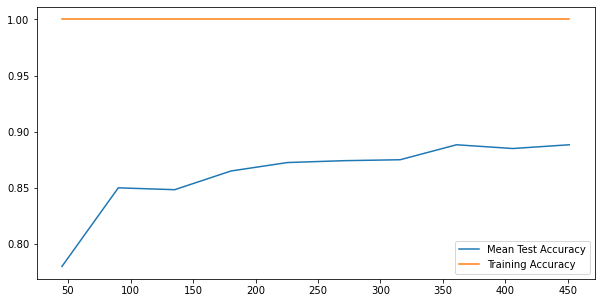

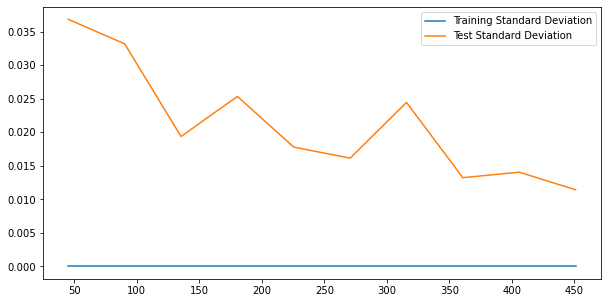

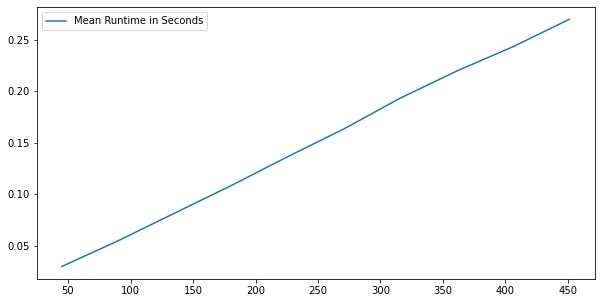

In [9]:
x = np.linspace(.1*train_images.shape[0], train_images.shape[0], 10)
acc, std, runtime, t_acc, t_std= run_percentage(train_zones, train_labels, test_zones, test_labels, 8)
print(acc, std, runtime, t_acc,t_std)
plt.figure(0,figsize = (10, 5))
plt.plot(x, acc[:], label = "Mean Test Accuracy")
plt.plot(x, t_acc[:], label = "Training Accuracy")
plt.legend()
plt.figure(1,figsize = (10, 5))
plt.plot(x, t_std[:], label = "Training Standard Deviation")
plt.plot(x, std[:], label = "Test Standard Deviation")
plt.legend()
plt.figure(2, figsize=(10,5))
plt.plot(x, runtime[:], label = "Mean Runtime in Seconds")
plt.legend()

In [10]:
def run_set_amount(images,zones, labels, weights, bias , num_pictures, random):
    classes = ('Not Face', 'Face')
    if random == True:
        available_indices = np.random.choice(len(zones[0][0]), num_pictures, replace = False)
        print(available_indices)
        available_zones = zones[:,:,available_indices]
        available_labels= labels[available_indices]
        print(available_labels)
        for i in range(num_pictures):
            arr = available_zones[:,:,i].ravel()
            b = np.dot(weights, arr) + bias
            p = 1
            if b < 0:
                p = 0
            print(f"Predicted: {classes[p]} | Truth: {classes[available_labels[i]]}")
            plt.imshow(images[available_indices[i],:,:])
            plt.show()
            
           
            
    else:
        available_zones = zones[:,:,0:num_pictures]
        available_labels= labels[0:num_pictures]
        for i in range(num_pictures):
            arr = available_zones[:,:,i].ravel()
            b = np.dot(weights, arr) + bias
            p = 1
            if b < 0:
                p = 0
            print(f"Predicted: {classes[p]} | Truth: {classes[available_labels[i]]}")
            plt.imshow(images[i,:,:])
            plt.show()
            



           


[ 47 149  32  70 138   9  99 103 113 148 116  86 111  45 112]
[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0]
Predicted: Face | Truth: Face


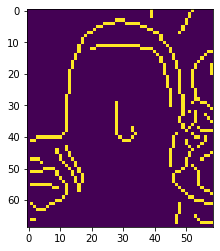

Predicted: Face | Truth: Not Face


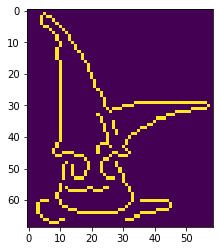

Predicted: Not Face | Truth: Not Face


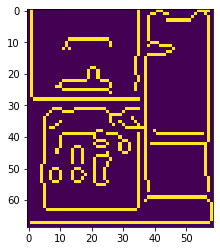

Predicted: Face | Truth: Face


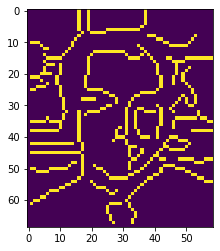

Predicted: Not Face | Truth: Not Face


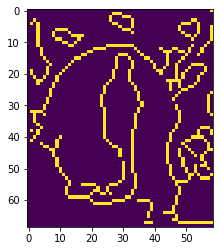

Predicted: Not Face | Truth: Not Face


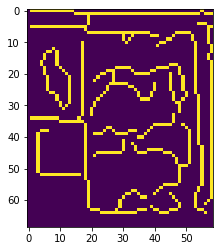

Predicted: Not Face | Truth: Not Face


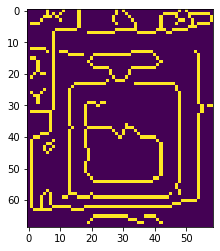

Predicted: Face | Truth: Face


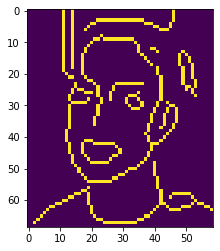

Predicted: Face | Truth: Face


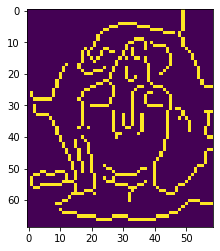

Predicted: Not Face | Truth: Not Face


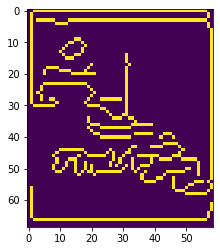

Predicted: Face | Truth: Face


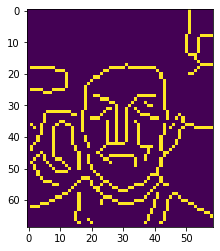

Predicted: Face | Truth: Not Face


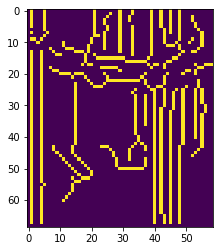

Predicted: Not Face | Truth: Not Face


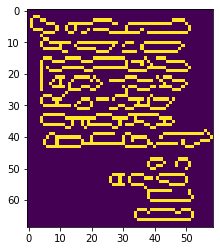

Predicted: Not Face | Truth: Not Face


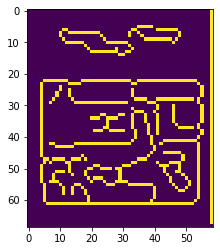

Predicted: Not Face | Truth: Not Face


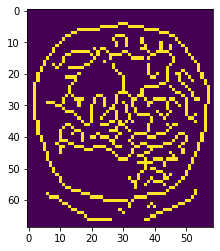

In [11]:
weights, bias, c = train_perceptron_faces(200, train_labels, train_zones)

run_set_amount(test_images,test_zones, test_labels, weights, bias, 15, True)